In [19]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.compute as pc
import pyarrow.dataset as ds
import math
import re
import ahocorasick
import datetime
from tqdm import tqdm

## Analysis of Canonical Peptides

In [20]:
parq_file = "/home1/wangd/project/PXD010154-pangenome-canonical-0.01.parquet"
table = pq.read_table(parq_file)
df = table.to_pandas()

In [21]:
df

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,is_decoy,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names
0,SLQQCQLGLNVLGSGTLVSPLQALTLR,"[DECOY_GRCh38_81202, DECOY_GCA_41693, DECOY_GC...","[241, 241, 241, 241]","[267, 267, 267, 267]",0.093415,0,"[5-UNIMOD:4, 10-UNIMOD:7]",4653.9424,3,956.525940,...,1,['OpenMS:Target-decoy PSM q-value': 0.00405585...,NaN,01524_A01_P015424_S00_N01_R1,27796,None,None,NaN,None,None
1,LPPGVDPAAVTSALSPEGVLSIQAAPASAQAPPPAAAK,"[GRCh38_40238, GCA_63102]","[123, 123]","[160, 160]",0.000503,0,[23-UNIMOD:7],5334.6455,3,1173.971558,...,0,['OpenMS:Target-decoy PSM q-value': 0.00017559...,NaN,01524_A01_P015424_S00_N01_R1,34850,None,None,NaN,None,None
2,IGAVLFTVVTPMINPFIYSLR,[GCA_179778],[273],[293],0.435029,1,"[12-UNIMOD:35, 14-UNIMOD:7]",4935.0220,3,790.451660,...,0,['OpenMS:Target-decoy PSM q-value': 0.00978584...,NaN,01524_A01_P015424_S00_N01_R1,30751,None,None,NaN,None,None
3,VDLLVFNPPYVVTPPQEVGSHGIEAAWAGGR,"[GRCh38_1991, GCA_56504, GCA_143784]","[116, 116, 116]","[146, 146, 146]",0.000503,0,[16-UNIMOD:7],5533.2837,3,1093.233154,...,0,['OpenMS:Target-decoy PSM q-value': 0.00982226...,NaN,01524_A01_P015424_S00_N01_R1,36751,None,None,NaN,None,None
4,AIQNSLVGEPILQNVLGSVTAVNR,[GCA_271209],[42],[65],0.351119,1,[14|23-UNIMOD:7],3774.0400,4,624.347168,...,0,['OpenMS:Target-decoy PSM q-value': 0.00648014...,NaN,01524_A01_P015424_S00_N01_R1,18657,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15590881,TPEVTCVVVDVSHEDPEVQFNWYVDGVEVHNAK,[GCA_249239],[135],[167],0.000503,1,"[6-UNIMOD:4, 21-UNIMOD:7]",5355.9000,4,950.705505,...,0,['OpenMS:Target-decoy PSM q-value': 3.70502765...,NaN,01307_D05_P013386_S00_N36_R1,41181,None,None,NaN,None,None
15590882,FNEEHIPDSPFVVPVASPSGDAR,"[GRCh38_20624, GCA_120257]","[2303, 2303]","[2325, 2325]",0.000503,0,[2-UNIMOD:7],4207.4000,3,823.739562,...,0,['OpenMS:Target-decoy PSM q-value': 0.00033439...,NaN,01307_D05_P013386_S00_N36_R1,31404,None,None,NaN,None,None
15590883,ILFIFIDSDHTDNQR,"[GRCh38_56460, GCA_82927]","[286, 286]","[300, 300]",0.000503,0,None,4688.1000,3,611.978349,...,0,['OpenMS:Target-decoy PSM q-value': 3.14206487...,NaN,01307_D05_P013386_S00_N36_R1,35481,None,None,NaN,None,None
15590884,SIPAYLAETLYYAMK,"[GRCh38_32181, GCA_15045]","[246, 246]","[260, 260]",0.000503,0,[14-UNIMOD:35],6118.2000,2,875.947326,...,0,['OpenMS:Target-decoy PSM q-value': 4.02448832...,NaN,01307_D05_P013386_S00_N36_R1,47417,None,None,NaN,None,None


In [22]:
#shorten accessions to save memory
def get_source(accessions):
    accessions = accessions.split(',')

    for acc in accessions:
        if acc.startswith('DECOY_CONTAMINANT'):
            return 'DECOY_CONTAMINANT'
    for acc in accessions:
        if acc.startswith('CONTAMINANT'):
            return 'CONTAMINANT'
    
    for acc in accessions:
        if acc.startswith('DECOY_GRCh38'):
            return 'DECOY_GRCh38'
    
    for acc in accessions:
        if acc.startswith('DECOY_GCA'):
            return 'DECOY_GCA'

    for acc in accessions:
        if acc.startswith('GRCh38'):
            return 'GRCh38'
    
    for acc in accessions:
        if acc.startswith('GCA'):
            return 'GCA'
    
    return accessions

In [23]:
print('Number of PSMs in the file = ', len(df))

Number of PSMs in the file =  15590886


In [24]:
#Convert array values in the accession to list
def join_vals(x):
    return ','.join(x.astype(str).tolist())

In [25]:
df['protein_accessions'] = df['protein_accessions'].apply(join_vals)

In [26]:
df

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,is_decoy,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names
0,SLQQCQLGLNVLGSGTLVSPLQALTLR,"DECOY_GRCh38_81202,DECOY_GCA_41693,DECOY_GCA_9...","[241, 241, 241, 241]","[267, 267, 267, 267]",0.093415,0,"[5-UNIMOD:4, 10-UNIMOD:7]",4653.9424,3,956.525940,...,1,['OpenMS:Target-decoy PSM q-value': 0.00405585...,NaN,01524_A01_P015424_S00_N01_R1,27796,None,None,NaN,None,None
1,LPPGVDPAAVTSALSPEGVLSIQAAPASAQAPPPAAAK,"GRCh38_40238,GCA_63102","[123, 123]","[160, 160]",0.000503,0,[23-UNIMOD:7],5334.6455,3,1173.971558,...,0,['OpenMS:Target-decoy PSM q-value': 0.00017559...,NaN,01524_A01_P015424_S00_N01_R1,34850,None,None,NaN,None,None
2,IGAVLFTVVTPMINPFIYSLR,GCA_179778,[273],[293],0.435029,1,"[12-UNIMOD:35, 14-UNIMOD:7]",4935.0220,3,790.451660,...,0,['OpenMS:Target-decoy PSM q-value': 0.00978584...,NaN,01524_A01_P015424_S00_N01_R1,30751,None,None,NaN,None,None
3,VDLLVFNPPYVVTPPQEVGSHGIEAAWAGGR,"GRCh38_1991,GCA_56504,GCA_143784","[116, 116, 116]","[146, 146, 146]",0.000503,0,[16-UNIMOD:7],5533.2837,3,1093.233154,...,0,['OpenMS:Target-decoy PSM q-value': 0.00982226...,NaN,01524_A01_P015424_S00_N01_R1,36751,None,None,NaN,None,None
4,AIQNSLVGEPILQNVLGSVTAVNR,GCA_271209,[42],[65],0.351119,1,[14|23-UNIMOD:7],3774.0400,4,624.347168,...,0,['OpenMS:Target-decoy PSM q-value': 0.00648014...,NaN,01524_A01_P015424_S00_N01_R1,18657,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15590881,TPEVTCVVVDVSHEDPEVQFNWYVDGVEVHNAK,GCA_249239,[135],[167],0.000503,1,"[6-UNIMOD:4, 21-UNIMOD:7]",5355.9000,4,950.705505,...,0,['OpenMS:Target-decoy PSM q-value': 3.70502765...,NaN,01307_D05_P013386_S00_N36_R1,41181,None,None,NaN,None,None
15590882,FNEEHIPDSPFVVPVASPSGDAR,"GRCh38_20624,GCA_120257","[2303, 2303]","[2325, 2325]",0.000503,0,[2-UNIMOD:7],4207.4000,3,823.739562,...,0,['OpenMS:Target-decoy PSM q-value': 0.00033439...,NaN,01307_D05_P013386_S00_N36_R1,31404,None,None,NaN,None,None
15590883,ILFIFIDSDHTDNQR,"GRCh38_56460,GCA_82927","[286, 286]","[300, 300]",0.000503,0,None,4688.1000,3,611.978349,...,0,['OpenMS:Target-decoy PSM q-value': 3.14206487...,NaN,01307_D05_P013386_S00_N36_R1,35481,None,None,NaN,None,None
15590884,SIPAYLAETLYYAMK,"GRCh38_32181,GCA_15045","[246, 246]","[260, 260]",0.000503,0,[14-UNIMOD:35],6118.2000,2,875.947326,...,0,['OpenMS:Target-decoy PSM q-value': 4.02448832...,NaN,01307_D05_P013386_S00_N36_R1,47417,None,None,NaN,None,None


In [27]:
df['prot_source'] = df['protein_accessions'].apply(get_source)

In [28]:
df['prot_source'].value_counts()

prot_source
GRCh38               10378371
GCA                   4486553
CONTAMINANT            571594
DECOY_GCA               99782
DECOY_GRCh38            53403
DECOY_CONTAMINANT        1183
Name: count, dtype: int64

#### blast GCA with canonical

In [29]:
fa_set = set()
for j in SeqIO.parse("/home1/wangd/project/can_db/Homo_sapiens.GRCh38.pep.all.fa", "fasta"):
    fa_set.add(str(j.seq))
for j in SeqIO.parse("/home1/wangd/project/can_db/uniprotkb_Homo_sapiens_AND_model_organi_2023_11_02.fasta", "fasta"):
    fa_set.add(str(j.seq))

In [30]:
def blast_with_caonical_fasta(peptide):
    for fasta in fa_set:
        if peptide in fasta:
            return "GRCh38"
    return "GCA"

In [31]:
start_time = datetime.datetime.now()
print(start_time)

seq_set = set(df["sequence"].to_list())
seq_dict = dict()
for i in tqdm(seq_set):
    seq_dict[i] = blast_with_caonical_fasta(i)

tqdm.pandas(desc='pandas bar')
df[df['prot_source']=="GCA"]['prot_source'] = df[df['prot_source']=="GCA"]['sequence'].progress_apply(lambda x: seq_dict.get(x))

end_time = datetime.datetime.now()
print("End time :", end_time)
set_time_taken = end_time - start_time
print("Time consumption :", set_time_taken)

2023-11-04 21:23:53.016981


pandas bar: 100%|██████████| 4486553/4486553 [00:02<00:00, 1589196.42it/s]


End time : 2023-11-05 01:27:56.422705
Time consumption : 4:04:03.405724


/tmp/ipykernel_2837570/2264385784.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['prot_source']=="GCA"]['prot_source'] = df[df['prot_source']=="GCA"]['sequence'].progress_apply(lambda x: seq_dict.get(x))


In [38]:
df['prot_source'].value_counts()

prot_source
GRCh38               10378371
GCA                   4486553
CONTAMINANT            571594
DECOY_GCA               99782
DECOY_GRCh38            53403
DECOY_CONTAMINANT        1183
Name: count, dtype: int64

In [39]:
df['prot_source'] = df.apply(lambda x: seq_dict.get(x['sequence']) if x['prot_source'] == 'GCA' else x['prot_source'], axis=1)

In [40]:
df['prot_source'].value_counts()

prot_source
GRCh38               14763055
CONTAMINANT            571594
GCA                    101869
DECOY_GCA               99782
DECOY_GRCh38            53403
DECOY_CONTAMINANT        1183
Name: count, dtype: int64

In [70]:
df2 = df[df['posterior_error_probability']<0.01]

gca = df2.loc[df2.prot_source.str.startswith("GCA")==True]
grch = df2.loc[df2.prot_source.str.startswith("GRCh38")==True]
decoy_grch = df2.loc[df2.prot_source.str.startswith("DECOY_GRCh38")==True]
decoy_gca = df2.loc[df2.prot_source.str.startswith("DECOY_GCA")==True]

#sns.df['posterior_error_probability']

plt.figure(figsize=(20, 10))
sns.distplot(gca['posterior_error_probability'], 
             hist=True, kde=True, label='GCA', color='blue')
sns.distplot(grch['posterior_error_probability'], 
             hist=True, kde=True, label='GRCh38', color='green')
sns.distplot(decoy_gca['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GCA', color='red')
sns.distplot(decoy_grch['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GRCh38', color='yellow')

plt.legend()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'GRCh38'),
  Text(1, 0, 'CONTAMINANT'),
  Text(2, 0, 'GCA'),
  Text(3, 0, 'DECOY_GRCh38'),
  Text(4, 0, 'DECOY_GCA'),
  Text(5, 0, 'DECOY_CONTAMINANT')])

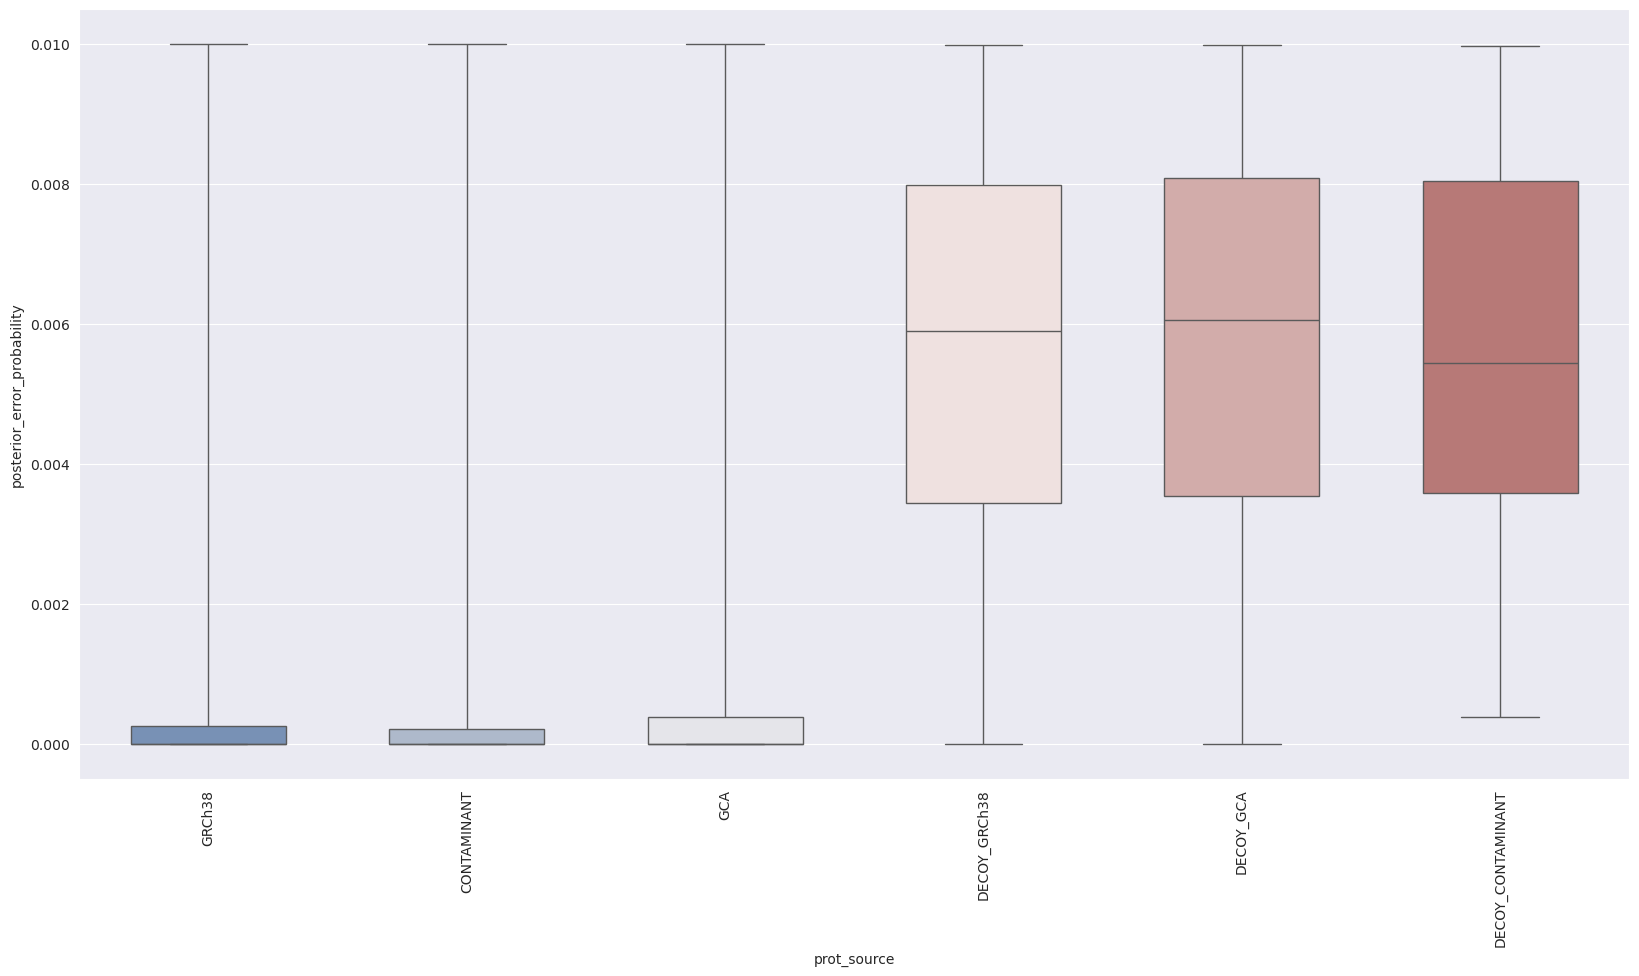

In [42]:
plt.figure(figsize=(20, 10))

sns.boxplot(
    df2, x="prot_source", y="posterior_error_probability", hue="prot_source",
    whis=[0, 100], width=.6, palette="vlag"
)
plt.xticks(rotation=90) 

In [43]:
df[df['posterior_error_probability']<0.01]['prot_source'].value_counts()

prot_source
GRCh38               12528591
CONTAMINANT            483633
GCA                     66465
DECOY_GCA                2125
DECOY_GRCh38             1089
DECOY_CONTAMINANT          47
Name: count, dtype: int64

In [44]:
print('Number of unique peptide sequences from\n GCA: {}\n canonical: {}'.format(len(gca.sequence.unique()), len(grch.sequence.unique())))
print('union', len(set(grch.sequence).union(set(gca.sequence))))
print('intesect', len(set(grch.sequence).intersection(set(gca.sequence))))

Number of unique peptide sequences from
 GCA: 4712
 canonical: 317430
union 322142
intesect 0


In [45]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [46]:
gca_seqs = list(set([rep(x) for x in gca['sequence'].tolist()]))

In [47]:
len(gca_seqs)

4712

In [48]:
#get all canonical sequences from fasta
canonical_proteins_fasta = '/home1/wangd/project/can_db/Homo_sapiens.GRCh38.pep.all.fa'
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))
print(len(allcan_seqs))

95816


In [49]:
#get non-canonical peptides that are found in canonical proteins
gca_found_peps = []
auto = ahocorasick.Automaton()
for gca_seq in gca_seqs:
    auto.add_word(gca_seq, gca_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        gca_found_peps.append(found)

In [50]:
print(len(set(gca_found_peps)))

0


In [51]:
gca_novel = gca[gca['sequence'].apply(rep).isin(gca_found_peps)==False]
print(len(gca_novel))

66465


In [52]:
print(len(set(gca_novel['sequence'].apply(rep).to_list())))

4712


#### To DeepLC

In [71]:
gca

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names,prot_source
84,ADEPQWSLYPSNSQVSEEVK,GCA_160389,[134],[153],0.000503,1,[12-UNIMOD:7],3837.8252,2,1148.028809,...,['OpenMS:Target-decoy PSM q-value': 7.46249466...,NaN,01524_A01_P015424_S00_N01_R1,19309,None,None,NaN,None,None,GCA
1725,MVAVQNYHGNPAPPGKPVLTFQTGDVLELLR,GCA_188144,[581],[611],0.000503,1,[22-UNIMOD:7],5076.4430,4,841.701599,...,['OpenMS:Target-decoy PSM q-value': 3.01421824...,NaN,01524_A01_P015424_S00_N01_R1,32236,None,None,NaN,None,None,GCA
1767,QVTSTASTFVKPIFSR,GCA_276583,[8],[23],0.000503,1,None,3641.3105,3,590.326721,...,['OpenMS:Target-decoy PSM q-value': 4.22368967...,NaN,01524_A01_P015424_S00_N01_R1,17326,None,None,NaN,None,None,GCA
1956,NHSVAESLNYVASWNMSMLQTQDLVK,GCA_64056,[284],[309],0.000503,1,"[1|15-UNIMOD:7, 18-UNIMOD:35]",5138.0977,3,995.479187,...,['OpenMS:Target-decoy PSM q-value': 8.79923317...,NaN,01524_A01_P015424_S00_N01_R1,32873,None,None,NaN,None,None,GCA
2279,QSGGSSQAGAVTVSDVQELMR,"GCA_5200,GCA_102666","[8, 8]","[28, 28]",0.000503,0,None,4081.6558,2,1054.513306,...,['OpenMS:Target-decoy PSM q-value': 3.14206487...,NaN,01524_A01_P015424_S00_N01_R1,21737,None,None,NaN,None,None,GCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15588256,VELQDWAGNEAYAEYHFR,GCA_252999,[726],[743],0.000503,1,[4-UNIMOD:7],3816.7000,3,733.996032,...,['OpenMS:Target-decoy PSM q-value': 4.33891917...,NaN,01293_D05_P013196_S00_N36_R1,24710,None,None,NaN,None,None,GCA
15588923,HILELQEVYDYLYQPSYR,GCA_248020,[1316],[1333],0.000503,1,[6-UNIMOD:7],4886.7000,3,777.724853,...,['OpenMS:Target-decoy PSM q-value': 5.07460837...,NaN,01293_D05_P013196_S00_N36_R1,33159,None,None,NaN,None,None,GCA
15589073,HILELQEVYDYLYQPSYR,GCA_248020,[1316],[1333],0.000503,1,None,4881.5000,3,777.391235,...,['OpenMS:Target-decoy PSM q-value': 4.86307472...,NaN,01293_D05_P013196_S00_N36_R1,33113,None,None,NaN,None,None,GCA
15589545,DVASLSSQIQDTQELLQEETR,GCA_293797,[1316],[1336],0.000503,1,None,5055.2000,2,1195.598449,...,['OpenMS:Target-decoy PSM q-value': 4.07343951...,NaN,01307_D05_P013386_S00_N36_R1,38639,None,None,NaN,None,None,GCA


In [72]:
grch

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names,prot_source
1,LPPGVDPAAVTSALSPEGVLSIQAAPASAQAPPPAAAK,"GRCh38_40238,GCA_63102","[123, 123]","[160, 160]",0.000503,0,[23-UNIMOD:7],5334.6455,3,1173.971558,...,['OpenMS:Target-decoy PSM q-value': 0.00017559...,NaN,01524_A01_P015424_S00_N01_R1,34850,None,None,NaN,None,None,GRCh38
10,QDLPNAMNAAEITDKLGLHSLR,GRCh38_94695,[128],[149],0.000503,1,[7-UNIMOD:35],4054.5593,4,606.564880,...,['OpenMS:Target-decoy PSM q-value': 3.62947179...,NaN,01524_A01_P015424_S00_N01_R1,21451,None,None,NaN,None,None,GRCh38
11,ETTFNSLLCPSGGEVSEELSLKLPPNVVEESAR,"GCA_3619,GCA_135944","[913, 913]","[945, 945]",0.000503,0,[9-UNIMOD:4],5199.6940,3,1196.932739,...,['OpenMS:Target-decoy PSM q-value': 3.14206487...,NaN,01524_A01_P015424_S00_N01_R1,33504,None,None,NaN,None,None,GRCh38
12,LGIWGGNVALDNLQIK,"GRCh38_62565,GCA_88022","[29, 29]","[44, 44]",0.000503,0,None,5091.0830,2,856.479858,...,['OpenMS:Target-decoy PSM q-value': 4.33891917...,NaN,01524_A01_P015424_S00_N01_R1,32388,None,None,NaN,None,None,GRCh38
13,FLLSDQSLLLLPEYHQR,GCA_235408,[1042],[1058],0.000503,1,[6-UNIMOD:7],5154.0034,3,691.713501,...,['OpenMS:Target-decoy PSM q-value': 1.31840142...,NaN,01524_A01_P015424_S00_N01_R1,33038,None,None,NaN,None,None,GRCh38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15590879,SYEDMIGEEVPSDQYYWAPLAQHER,"GRCh38_65113,GCA_22717","[320, 320]","[344, 344]",0.000503,0,[5-UNIMOD:35],4204.3000,3,1010.450349,...,['OpenMS:Target-decoy PSM q-value': 3.14206487...,NaN,01307_D05_P013386_S00_N36_R1,31378,None,None,NaN,None,None,GRCh38
15590880,EWYGYHFPELVK,"GRCh38_3800,GCA_67628","[191, 191]","[202, 202]",0.000503,0,None,4205.7000,3,523.594421,...,['OpenMS:Target-decoy PSM q-value': 0.00021070...,NaN,01307_D05_P013386_S00_N36_R1,31390,None,None,NaN,None,None,GRCh38
15590881,TPEVTCVVVDVSHEDPEVQFNWYVDGVEVHNAK,GCA_249239,[135],[167],0.000503,1,"[6-UNIMOD:4, 21-UNIMOD:7]",5355.9000,4,950.705505,...,['OpenMS:Target-decoy PSM q-value': 3.70502765...,NaN,01307_D05_P013386_S00_N36_R1,41181,None,None,NaN,None,None,GRCh38
15590883,ILFIFIDSDHTDNQR,"GRCh38_56460,GCA_82927","[286, 286]","[300, 300]",0.000503,0,None,4688.1000,3,611.978349,...,['OpenMS:Target-decoy PSM q-value': 3.14206487...,NaN,01307_D05_P013386_S00_N36_R1,35481,None,None,NaN,None,None,GRCh38


In [74]:
mod_rep = {"UNIMOD:4":"Carbamidomethyl","UNIMOD:7":"Deamidated","UNIMOD:35":"Oxidation","UNIMOD:1":"Acetyl"}
def replace_mod(x):
    s = ""
    for mod in x:
        nums = mod.split("-")[0]
        m = mod.split("-")[1]
        for n in nums.split("|"):
            if s:
                s += "|"
            s += n + "|" + mod_rep.get(m)
    return s

In [75]:
gca.loc[:,"seq"] = gca.apply(lambda x : x["sequence"],axis = 1)
gca.loc[:,"modifications"] = gca.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
gca.loc[:,"tr"] = gca.apply(lambda x : x["retention_time"],axis = 1)

In [76]:
grch.loc[:,"seq"] = grch.apply(lambda x : x["sequence"],axis = 1)
grch.loc[:,"modifications"] = grch.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
grch.loc[:,"tr"] = grch.apply(lambda x : x["retention_time"],axis = 1)

In [77]:
gca.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
grch.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
gca['modifications'] = gca['modifications'].fillna("")
grch['modifications'] = grch['modifications'].fillna("")

In [69]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

In [68]:
# obtain three models for deeplc
urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5",
    "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",
    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",
    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
)

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names,prot_source,seq,tr
1,LPPGVDPAAVTSALSPEGVLSIQAAPASAQAPPPAAAK,"GRCh38_40238,GCA_63102","[123, 123]","[160, 160]",0.000503,0,23|Deamidated,5334.6455,3,1173.971558,...,01524_A01_P015424_S00_N01_R1,34850,None,None,NaN,None,None,GRCh38,LPPGVDPAAVTSALSPEGVLSIQAAPASAQAPPPAAAK,5334.6455
10,QDLPNAMNAAEITDKLGLHSLR,GRCh38_94695,[128],[149],0.000503,1,7|Oxidation,4054.5593,4,606.564880,...,01524_A01_P015424_S00_N01_R1,21451,None,None,NaN,None,None,GRCh38,QDLPNAMNAAEITDKLGLHSLR,4054.5593
11,ETTFNSLLCPSGGEVSEELSLKLPPNVVEESAR,"GCA_3619,GCA_135944","[913, 913]","[945, 945]",0.000503,0,9|Carbamidomethyl,5199.6940,3,1196.932739,...,01524_A01_P015424_S00_N01_R1,33504,None,None,NaN,None,None,GRCh38,ETTFNSLLCPSGGEVSEELSLKLPPNVVEESAR,5199.6940
12,LGIWGGNVALDNLQIK,"GRCh38_62565,GCA_88022","[29, 29]","[44, 44]",0.000503,0,,5091.0830,2,856.479858,...,01524_A01_P015424_S00_N01_R1,32388,None,None,NaN,None,None,GRCh38,LGIWGGNVALDNLQIK,5091.0830
13,FLLSDQSLLLLPEYHQR,GCA_235408,[1042],[1058],0.000503,1,6|Deamidated,5154.0034,3,691.713501,...,01524_A01_P015424_S00_N01_R1,33038,None,None,NaN,None,None,GRCh38,FLLSDQSLLLLPEYHQR,5154.0034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15587701,MENEFYEFALEQFQFIR,"GRCh38_92499,GCA_35387","[312, 312]","[328, 328]",0.000503,0,1|Oxidation|3|12|Deamidated,6196.9000,2,1130.523010,...,01306_D05_P013385_S00_N36_R1,46251,None,None,NaN,None,None,GRCh38,MENEFYEFALEQFQFIR,6196.9000
15587737,YMDEDGEWWIAK,"GRCh38_7423,GCA_50544","[39, 39]","[50, 50]",0.000503,0,2|Oxidation,3799.0000,2,779.831237,...,01306_D05_P013385_S00_N36_R1,24855,None,None,NaN,None,None,GRCh38,YMDEDGEWWIAK,3799.0000
15588175,LVNLYGLLHGLQAAVAQQDTLMEAR,"GRCh38_93342,GCA_13456","[885, 885]","[909, 909]",0.000503,0,3|17|Deamidated|22|Oxidation,5950.1000,3,915.158569,...,01293_D05_P013196_S00_N36_R1,41152,None,None,NaN,None,None,GRCh38,LVNLYGLLHGLQAAVAQQDTLMEAR,5950.1000
15588726,DYYFDSYAHFGIHEEMLK,"GRCh38_51203,GCA_64989","[33, 33]","[50, 50]",0.000503,0,16|Oxidation,3690.0000,3,761.337829,...,01293_D05_P013196_S00_N36_R1,23740,None,None,NaN,None,None,GRCh38,DYYFDSYAHFGIHEEMLK,3690.0000


#### Transfer learning

In [ ]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
grch.to_csv("grch.csv",index=False)
df_train_file = "grch.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=["full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5",
                            "full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5","full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5"],
    freeze_layers=True,
    n_epochs=10,
    freeze_after_concat=1
);

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=grch)
preds_transflearn = dlc.make_preds(seq_df=gca)

mae_transflearn = sum(abs(gca["tr"]-preds_transflearn))/len(gca["tr"].index)
perc95_transflearn = np.percentile(abs(gca["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(gca["tr"],preds_transflearn)[0]

In [ ]:
gca['pred_rt'] = preds_transflearn

In [ ]:
gca.to_csv('gca.tsv',sep='\t', index=False)
grch.to_csv('grch.tsv',sep='\t', index=False)